# Purpose

**Identify which factors predict future user adoption**

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days in at least  one  seven day  period, identify  which  factors  predict  future  user adoption .

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Wrangling

## Import Data

In [2]:
path = 'takehome_user_engagement.csv'
user_engagement = pd.read_csv(path)

In [3]:
path = 'takehome_users.csv'
users = pd.read_csv(path, encoding='latin-1')

## Data Cleaning

In [4]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
# Convert time_stamp to datetime format
user_engagement.time_stamp = pd.to_datetime(user_engagement.time_stamp)

In [9]:
user_engagement.sort_values(by='time_stamp', inplace=True)

# Feature Engineering

## Adopted

In [10]:
import datetime as dt

In [11]:
# Create a dictionary to store whether a user has been adopted or not
adopted_dict = {id:0 for id in users.object_id}

In [12]:
# For each user id find if there are 3 logins within 7 days of each other.
# If and once found, set that user id in the dictionary to 1 and move on to the next user id.
for id in user_engagement.user_id.unique():
    query = user_engagement.query(f'user_id == {id}')
    length = query.shape[0]
    for idx in range(length - 2):
        start = query.iloc[idx, 0]
        end = query.iloc[idx + 2, 0]
        time_range = start + dt.timedelta(days=7)
        if end < time_range:
            adopted_dict[id] = 1
            break

In [13]:
# Add dictionary values to users DataFrame
users['adopted'] = users.object_id.apply(lambda x: adopted_dict[x])

## Features to Numeric for ML

In [28]:
users_ML = users.copy(deep=True)

In [29]:
# Convert creation_time to a datetime and then numeric
users_ML.creation_time = pd.to_datetime(users_ML.creation_time).apply(lambda x: x.value)

In [30]:
users_ML.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,1398138780000000000,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0


In [31]:
# Convert categorical column to numeric
users_ML = pd.get_dummies(users_ML, columns=['creation_source'])

# Remove unhelpful columns
users_ML = users_ML.drop(columns=['object_id','name','email'])

In [32]:
# Fill NaNs with 0
users_ML.fillna(0, inplace=True)

# Identify which factors predict future user adoption

## ML

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X = users_ML.drop(columns='adopted')
y = users_ML.adopted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

In [36]:
tree = DecisionTreeClassifier(max_depth=4)
cv = cross_validate(tree, X, y, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [37]:
cv

{'fit_time': array([0.01401305, 0.01301193, 0.01301098, 0.01201129, 0.0140121 ]),
 'score_time': array([0.00100064, 0.00100064, 0.00100112, 0.00200176, 0.00100112]),
 'test_score': array([0.965     , 0.96125   , 0.96416667, 0.95666667, 0.95625   ])}

In [38]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.958

In [39]:
pd.DataFrame(data=tree.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)

,0
last_session_creation_time,0.628273
creation_time,0.369676
invited_by_user_id,0.002051
opted_in_to_mailing_list,0.000000
enabled_for_marketing_drip,0.000000
org_id,0.000000
creation_source_GUEST_INVITE,0.000000
creation_source_ORG_INVITE,0.000000
creation_source_PERSONAL_PROJECTS,0.000000
creation_source_SIGNUP,0.000000


## EDA

### Correlations

In [40]:
def gen_corr_to_target(dataframe, target, title=None, annot=False, save=None):
    '''Generate a correlation heatmap between the target feature and other features'''
    plt.figure(figsize=(4, 6))
    sns.set(font_scale=1)

    sns.heatmap(dataframe.corr()[[target]].sort_values(target, ascending=False)[1:], vmin=-1, vmax=1,
                center=0, annot=annot, cmap='bwr')

    if title:
        plt.title(f'\n{title}\n', fontsize=18)
        
    if save:
        filepath = title + '.png'
        save_and_show_plot(filepath)

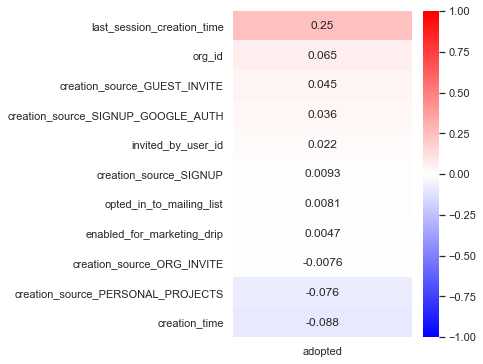

In [41]:
gen_corr_to_target(users_ML, 'adopted', annot=True)

### Plots

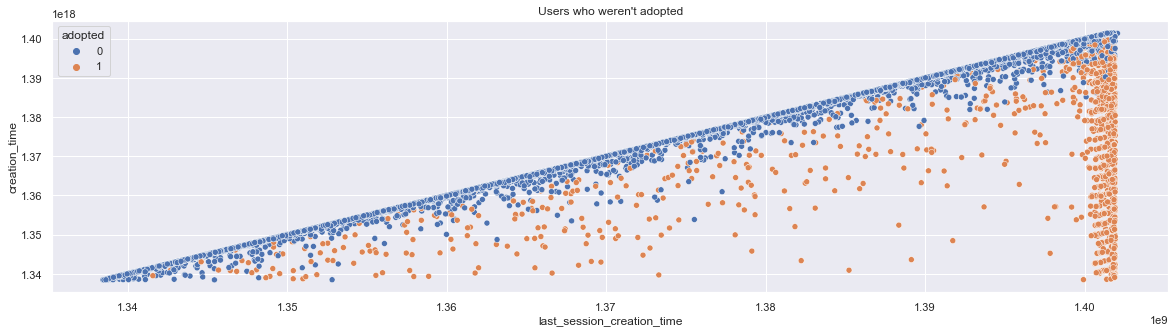

In [79]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=users_ML.query('last_session_creation_time > 0'), x='last_session_creation_time', y='creation_time', hue='adopted', hue_order=[0,1])
plt.title('Users who weren\'t adopted');

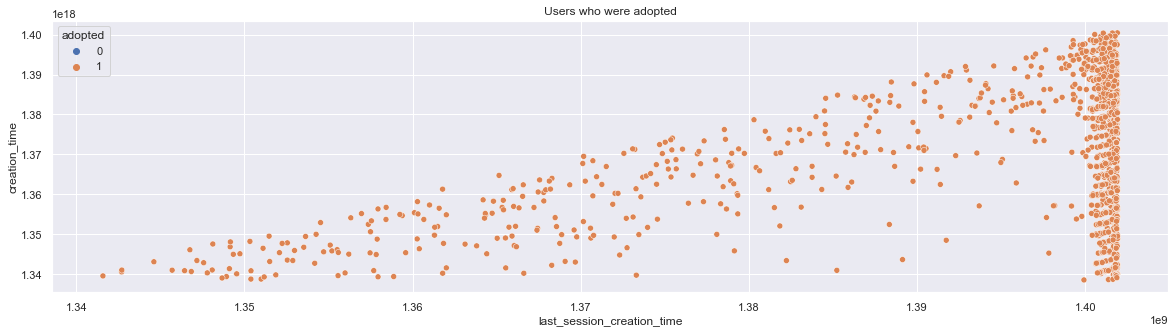

In [75]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=users_ML.query('last_session_creation_time > 0 & adopted == 1'), x='last_session_creation_time', y='creation_time', hue='adopted', hue_order=[0,1])
plt.title('Users who were adopted');

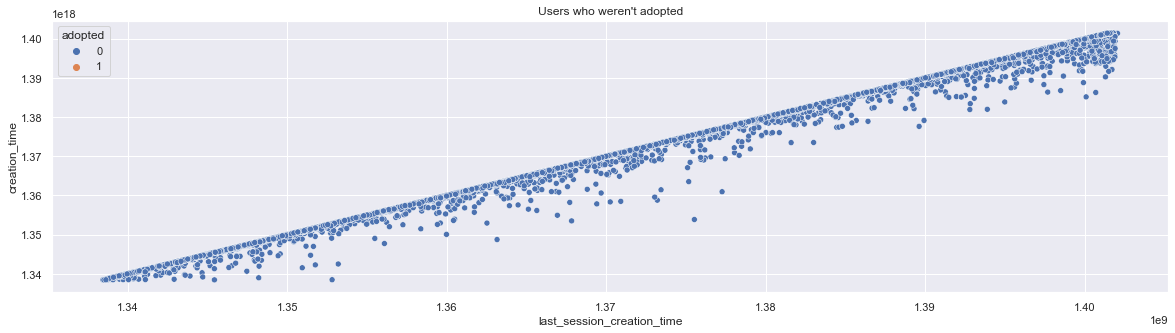

In [77]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=users_ML.query('last_session_creation_time > 0 & adopted == 0'), x='last_session_creation_time', y='creation_time', hue='adopted', hue_order=[0,1])
plt.title('Users who weren\'t adopted');

# Findings Summary

Last session creation time was the most useful factor to predict user adoption. Specifically, if a user created a session as recently as they possibly could they were much more likely to be adopted.

The second most useful factor was creation time, as in when a user created their account. The further in the past from their most recent session, the more likely they are to be adopted.

In [74]:
# Ratio of users with last_session_creation_time > 1.395e9 who are "adopted"
_ = users.query('last_session_creation_time > 1.395e9').adopted.agg(['count','sum']).values
_[1] / _[0]

0.46060606060606063

In [73]:
# Ratio of users with last_session_creation_time <= 1.395e9 who are "adopted"
_ = users.query('last_session_creation_time <= 1.395e9').adopted.agg(['count','sum']).values
_[1] / _[0]

0.051512130275839146